# Projeto Final – Identificação de Fraude nos Emails da Eron
Curso: Fundamentos de Data Science II

Aluno: Filipe Pegollo

## Introdução
  
  Em 2000, Enron era uma das maiores empresas dos Estados Unidos. Já em 2002, ela colapsou e quebrou devido a uma fraude que envolveu grande parte da corporação. Resultando em uma investigação federal, muitos dados que são normalmente confidenciais, se tornaram públicos, incluindo dezenas de milhares de e-mails e detalhes financeiros para os executivos dos mais altos níveis da empresa. Este projeto tem o objetivo de analisar dados financeiros e e-mails da empresa e através de técnicas de machine learning avaliar diversas características que possam identificar pessoas com grandes chances de envolvimento. 

## Avaliando os dados

In [2]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import numpy as np
from numpy.core.umath_tests import inner1d
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Apenas para não exibir as mensagens de atenção do F1-score
# por haver de poucos dados de treinamento
import warnings
warnings.filterwarnings('ignore')

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from tester import test_classifier


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# RESPOSTA: Adicionando recursos para avaliação
features_list = ['poi', 'bonus',  'deferral_payments', 'deferred_income', 'director_fees',
                 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person',
                 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 
                 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
                 'to_messages', 'total_stock_value', 'total_payments']


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)


# Armazenando em um Dataframe Pandas para facilitar a análise
df = pd.DataFrame.from_dict(data_dict, orient='index')
# Atualizando os valores com 'NaN' para nulos
df.replace(to_replace='NaN', value=np.nan, inplace=True)

Vizualizando amostra dos dados

In [3]:
df.head(5)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,NaN,4175000.0,phillip.allen@enron.com,-126027.0,-3081055.0,1729541.0,...,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,NaN
BADUM JAMES P,NaN,NaN,178980.0,182466.0,NaN,NaN,NaN,NaN,NaN,257817.0,...,NaN,257817.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,NaN,NaN,james.bannantine@enron.com,-560222.0,-5104.0,5243487.0,...,39.0,4046157.0,29.0,864523.0,0.0,False,NaN,465.0,1757552.0,NaN
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,NaN,-1386055.0,10623258.0,...,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,frank.bay@enron.com,-82782.0,-201641.0,63014.0,...,NaN,NaN,NaN,69.0,NaN,False,NaN,NaN,145796.0,NaN


Verificando informações sobre o dataset

In [4]:
# EXPLORANDO DADOS
# Total de Registros -1 para não contar o cabeçalho
total_r = df.shape[0] -1
print('\nTotal de Registros no Dataset:', total_r)

# Verifica se possui itens duplicados
if df.duplicated().sum() > 0:
    print('{} itens duplicados'.format(df.duplicated().count()))
else:
    print('O dataset não possui itens duplicados')  

# Verificando o total de POIs
total_p = df['poi'].sum()
print('Total de POIS:', total_p)

# Verificando o total de Não POIs
total_np = total_r - total_p
print('Total de Não-POIS:',total_np)

# Verificando o total de características
print('Total de Catacterísticas:', df.shape[1])


Total de Registros no Dataset: 145
O dataset não possui itens duplicados
Total de POIS: 18
Total de Não-POIS: 127
Total de Catacterísticas: 21


Para ter um panorama do dataset vamos fazer um levantamento do total de valores faltantes e depois calcular a proporção em relação ao total e gerar um gráfico.


Valores ausentes e proporção de itens faltantes:
                            total_a     prop_a
loan_advances                  142  97.260274
director_fees                  129  88.356164
restricted_stock_deferred      128  87.671233
deferral_payments              107  73.287671
deferred_income                 97  66.438356
long_term_incentive             80  54.794521
bonus                           64  43.835616
from_messages                   60  41.095890
shared_receipt_with_poi         60  41.095890
from_this_person_to_poi         60  41.095890
to_messages                     60  41.095890
from_poi_to_this_person         60  41.095890
other                           53  36.301370
salary                          51  34.931507
expenses                        51  34.931507
exercised_stock_options         44  30.136986
restricted_stock                36  24.657534
email_address                   35  23.972603
total_payments                  21  14.383562
total_stock_value            

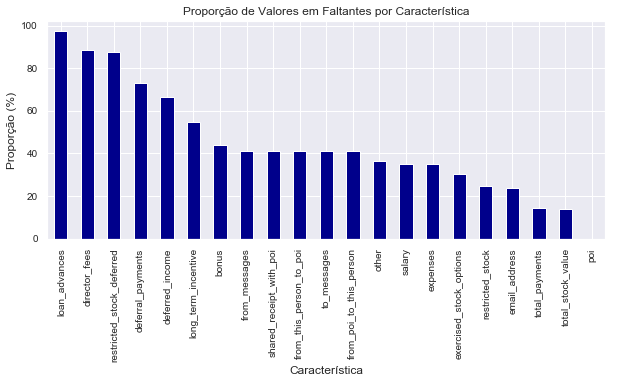

In [5]:
# Verificando o total de valores ausentes por característica
ausentes = df.isna().sum()
# Convertendo em um dataframe para facilitar a manipulação
ausentes = pd.Series.to_frame(ausentes)
ausentes.columns = ['total_a']
ausentes['prop_a'] = (ausentes['total_a'] / df.shape[0]) * 100
ausentes = ausentes.sort_values(['prop_a'], ascending=False)
print('\nValores ausentes e proporção de itens faltantes:\n', ausentes)

# Criando um gráfico de barras para melhor vizualização
ausentes['prop_a'].plot(kind='bar', fontsize=10, figsize=(10,4), rot=90, color='darkblue')
plt.title('Proporção de Valores em Faltantes por Característica', fontsize=12)
plt.xlabel('Característica',fontsize=12)
plt.ylabel('Proporção (%)',fontsize=12) 
plt.show()

Como pode ser visto algumas características tem mais de 80% de valores faltantes e `loan_advances` chegando a quase 100%, estas características tratam-se valores de ações, empréstimos. Este levantamento traz informações úteis que podem ajudar a selecionar e a entender a fase de seleção de recursos.

## Identificação de Outliers
É de extrema importancia fazer a identificação e tratamento de outliers na base de dados, pois podem causar erros e valores incoerentes nas fases de análise

Por haver muitas características com valores nulos, vamos criar um código para verificar se há algum registro com todos valores em branco

In [6]:
# Verifica e imprime os registros com todos valores ausentes
index = 0
print('\nRegistros com todos valores em branco:')
for total in pd.isnull(df).sum(axis = 1):
    if total == len(df.columns)-1:
        print(df.index[index])
    index += 1


Registros com todos valores em branco:
LOCKHART EUGENE E


Para ajudar na identificação de outros registros que possam ter valores muito fora da média vamos criar um gráfico do tipo boxplot

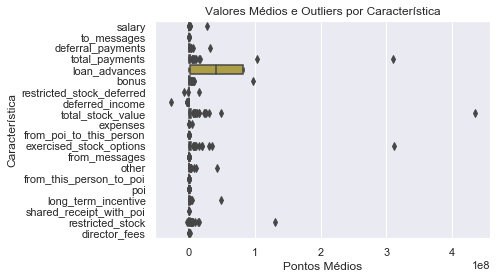

In [7]:
# Criando um gráfico de valores médios para procurar outliers
sns.boxplot(data=df, orient="h")
plt.title('Valores Médios e Outliers por Característica', fontsize=12)
plt.xlabel('Pontos Médios',fontsize=12)    
plt.ylabel('Característica',fontsize=12)
plt.show()

Agora vamos localizar o registro do maior outlier identificado no gráfico

In [8]:
# Imprimindo para identificar o outlier mostrado no grafico
print('\nOutliers com "total_stock_value" acima de 4e8:\n', df.index[df['total_stock_value'] >= 400000000])


Outliers com "total_stock_value" acima de 4e8:
 Index(['TOTAL'], dtype='object')


Após a identificação iremos remover os dois outliers localizados programaticamente e outro 'THE TRAVEL AGENCY IN THE PARK' que foi identificado através da análise visual, pelo nome é possível ver que este registro trata-se de uma empresa e não uma pessoa.

In [9]:
# Removendo Outliers
try:
    data_dict.pop('TOTAL')
    data_dict.pop('LOCKHART EUGENE E')
    data_dict.pop('THE TRAVEL AGENCY IN THE PARK')
    print('Outliers excluídos com sucesso!')
except:
    print('Erro ao excluir outliers')

Outliers excluídos com sucesso!


## Criação de novos recursos
Com o objetivo de melhorar o desempenho do algoritmo iremos criar três novas novas características `prop_bonus`, `prop_from_poi` e `prop_to_poi` que calculam a proporção de bonus em relação ao salário as proporções de mensagens enviadas e recebidas de POIs em relação ao total de mensagens.

In [10]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Extraindo rótulos e características do dataset
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# RESPOSTA: Criando novos recursos
for person in my_dataset.values():
    person['prop_bonus'] = 0
    person['prop_from_poi'] = 0
    person['prop_to_poi'] = 0
    
    # Criando uma variável com a proporção de bonus recebido em relação ao salário
    if float(person['bonus']) > 0:
        person['prop_bonus'] = float(person['bonus']) / float(person['salary'])
        
    # Criando uma variável com mensagens recebidas de POIs em relação ao total
    if person['to_messages'] != 'NaN' and person['from_poi_to_this_person'] != 'NaN':
        person['prop_from_poi'] = float(person['from_poi_to_this_person']) / float(person['to_messages'])

    # Criando uma variável com mensagens enviadas a POIs em relação ao total
    if person['from_messages'] != 'NaN' and person['from_this_person_to_poi'] != 'NaN':
        person['prop_to_poi'] = float(person['from_this_person_to_poi']) / float(person['from_messages'])


new_features = features_list + (['prop_bonus', 'prop_from_poi', 'prop_to_poi'])

## Seleção e avaliação de recursos
Para avaliar o desempenho das características iremos criar uma função que utiliza o algoritmo `SelectKBest` para ranquear e imprimir as melhores. Esta função poderá ser utilizada posteriormente nos testes com os classificadores para selecionar o número ideal de recursos com os melhores desempenhos.

In [11]:
# Criando uma função com o algoritmo K-Best para selecionar os melhores recursos
def best_features(n_features, l_features, show):
    """ 
    Classifica e imprime o número de recursos desejados com melhor pontuação.    
    
    Argumentos:
        n_features: Número de melhores recursos
        l_features: Lista com os recursos que deseja avaliar
        show: 's' ou 'n', 's' imprime os resultados
                
    Retorna:
        Lista com os recursos de maior pontuação
    """
    data = featureFormat(my_dataset, l_features, sort_keys=True)
    labels, features = targetFeatureSplit(data)
    clf_f = SelectKBest(k = n_features)
    clf_f = clf_f.fit(features, labels)
    results_list = zip(clf_f.get_support(), l_features[1:], clf_f.scores_)
    results_list = sorted(results_list, key=lambda x: x[2], reverse=True)
    count = 1
    # O primeiro recurso deve ser POI conforme tarefa 1
    bf_list = ['poi']
    
    if show == 's':     
        print('\nMelhores Recursos:')
        for r in results_list:
            if r[0]:
                print(count,'-', r[1], ':', r[2])
                count += 1
                bf_list.append(r[1])
    else:
        for r in results_list:
            if r[0]:
                bf_list.append(r[1])

    return bf_list
    

# Testando a função para avaliar as 10 melhores características
best_features(10, new_features, 's')


Melhores Recursos:
1 - exercised_stock_options : 24.815079733218194
2 - total_stock_value : 24.18289867856688
3 - bonus : 20.792252047181535
4 - salary : 18.289684043404513
5 - prop_to_poi : 16.40971254803579
6 - deferred_income : 11.458476579280369
7 - prop_bonus : 10.783584708160824
8 - long_term_incentive : 9.922186013189823
9 - restricted_stock : 9.2128106219771
10 - total_payments : 8.772777730091676


['poi',
 'exercised_stock_options',
 'total_stock_value',
 'bonus',
 'salary',
 'prop_to_poi',
 'deferred_income',
 'prop_bonus',
 'long_term_incentive',
 'restricted_stock',
 'total_payments']

Os resultados iniciais mostraram-se favoráveis, já que das três criadas duas estavam entre as 10 melhores.

## Seleção de classificador e número de recursos
O número de características utilizadas será selecionado sistematicamente através da criação de um algoritmo, que mede o desempenho de cada classificador de acordo com cada número de recursos, informando o número ideal e imprimindo um gráfico para avaliação do desempenho, os classificadores testados serão `Naive Bayes`, `Decision Tree` e `AdaBoost`.

O objetivo final deste projeto é atingir pelo menos 0,3 de precisão e recall, por isso  a métrica utilizada para avaliar os classificadores e número de recursos será Score-F1, esta métrica combina valores de precisão e recall em uma pontuação equilibrada.


Teste de Classificadores 1/3:
    acuracia classificador  f1_score  recursos
57  0.906977   Naive Bayes       0.6        20
    acuracia  classificador  f1_score  recursos
16  0.833333  Decision Tree  0.533333         6
    acuracia classificador  f1_score  recursos
35  0.906977      AdaBoost       0.6        12


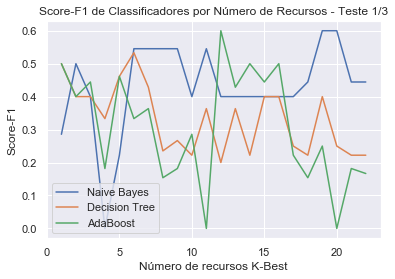


Melhor Classificador:
     acuracia classificador  f1_score  recursos
57  0.906977   Naive Bayes       0.6        20
-----------------------------------------------


Teste de Classificadores 2/3:
    acuracia classificador  f1_score  recursos
57  0.906977   Naive Bayes       0.6        20
    acuracia  classificador  f1_score  recursos
13      0.85  Decision Tree  0.571429         5
    acuracia classificador  f1_score  recursos
32  0.883721      AdaBoost  0.615385        11


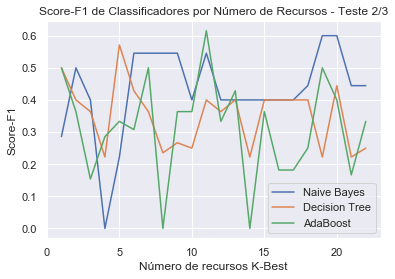


Melhor Classificador:
     acuracia classificador  f1_score  recursos
32  0.883721      AdaBoost  0.615385        11
-----------------------------------------------


Teste de Classificadores 3/3:
    acuracia classificador  f1_score  recursos
57  0.906977   Naive Bayes       0.6        20
   acuracia  classificador  f1_score  recursos
1  0.878788  Decision Tree       0.5         1
    acuracia classificador  f1_score  recursos
65  0.906977      AdaBoost       0.6        22


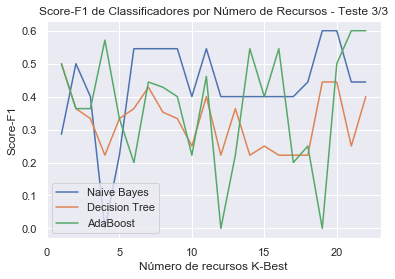


Melhor Classificador:
     acuracia classificador  f1_score  recursos
65  0.906977      AdaBoost       0.6        22
-----------------------------------------------



In [12]:
# Testando o melhor número de recursos em cada classificador
for test in range(1,4):
    print('\nTeste de Classificadores {}/3:'.format(test))
    scores = []

    for f in range(1, len(new_features)):
        n_features = best_features(f, new_features, 'n')
        data = featureFormat(my_dataset, n_features, sort_keys = True)
        labels, features = targetFeatureSplit(data)
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

        # Testando recursos com Naive Bayes
        clf_nb = GaussianNB()
        clf_nb.fit(features_train, labels_train)
        pred_nb = clf_nb.predict(features_test)
        acc_nb = accuracy_score(labels_test, pred_nb)
        f1s_nb = f1_score(labels_test, pred_nb)
        scores.append({'classificador': 'Naive Bayes', 'recursos': f, 'acuracia': acc_nb, 'f1_score':f1s_nb})

        # Testando recursos com Decision Tree     
        clf_dt = DecisionTreeClassifier()
        clf_dt = clf_dt.fit(features_train, labels_train)
        pred_dt = clf_dt.predict(features_test)
        acc_dt = accuracy_score(labels_test, pred_dt)
        f1s_dt = f1_score(labels_test, pred_dt)
        scores.append({'classificador': 'Decision Tree', 'recursos': f, 'acuracia': acc_dt, 'f1_score':f1s_dt})

        # Testando recursos com Adaboost em Decision Tree
        dct_cl = DecisionTreeClassifier(random_state = 11, max_features = "auto", max_depth = None)
        clf_ad = AdaBoostClassifier(base_estimator=dct_cl)
        clf_ad = clf_ad.fit(features_train, labels_train)
        pred_ad = clf_ad.predict(features_test)
        acc_ad = accuracy_score(labels_test, pred_ad)
        f1s_ad = f1_score(labels_test, pred_ad)
        scores.append({'classificador': 'AdaBoost', 'recursos': f, 'acuracia': acc_ad, 'f1_score':f1s_ad})


    # Convertendo os resultados em um Dataframe para facilitar impressão e análise
    scores = pd.DataFrame(scores)  

    # Criando um gráfico de linhas com os resultados
    for cl in (scores['classificador'].unique()):
        plt.plot(scores[scores['classificador'] == cl]['recursos'], scores[scores['classificador'] == cl]['f1_score'], label=cl)

        # Imprimindo os melhores resultados de cada classificador
        print(scores[(scores.classificador == cl) & (scores['f1_score'] == scores[scores.classificador == cl].f1_score.max())].tail(1))

    plt.title('Score-F1 de Classificadores por Número de Recursos - Teste {}/3'.format(test)) 
    plt.xlabel('Número de recursos K-Best')
    plt.ylabel('Score-F1')
    plt.legend()
    plt.show()

    # Informando o classificador e número de recursos com melhor score
    print('\nMelhor Classificador:\n', scores[scores['f1_score'] == scores['f1_score'].max()].tail(1))
    print('-----------------------------------------------\n')

Pelo fato do número de características ideal ser variável ele será selecionado sistematicamente durante a execução do algoritmo.

## Escolha e ajuste de parâmetros do classificador
Durante os testes realizados no desenvolvimento do projeto o classificador `AdaBoost` teve o melhor desempenho, ainda assim o  `Naive Bayes` teve um desempenho muito semelhante a algumas vezes superior, porém o escolhido foi o `AdaBoost` por ter um maior potencial de ajustes de parâmetros. O `AdaBoost` é um classificador que se adapta criando cópias onde o peso de classificações negativas são ajustadas e pode ser utilizado em conjunto com outros classificadores, neste caso iremos utilizar o `AdaBoost` com `DecisionTree` que é o classificador base padrão.

Testar diversos parâmetros é importante para que se obtenha os melhores ajustes do classificador para cada caso, por isso utilizaremos o `GridSearchCV` para encontrar a melhor combinação de parâmetros e recursos.

Os parâmetros testados serão:
* `base_estimator__criterion`: Mede a qualidade da divisão, `gini` através de impurezas e `entropy` através de ganho de informação.
* `base_estimator__splitter`: Escolhe os nós de divisão, `best` escolhe a melhor divisão ou `random` para divisões aleatórias.
* `n_estimators`: Número máximo de estimadores que serão criados.
* `learning_rate`: Peso de contribuição de cada modelo.


In [13]:
# Utilizando GridSearchCV para encontrar a melhor combinação e parâmetros e recursos
score_grid = 0
print("Ajustando parâmetros do classificador...\n")

for f in range(2, len(new_features)):
    n_features = best_features(f, new_features, 'n')
    data = featureFormat(my_dataset, n_features, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Informando parametros a serem testados 
    param_grid = {
                  "base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "n_estimators": [1, 50, 100],
                  "learning_rate": [1, 0.7, 0.5]
                  }

    # Criando os Classificadores
    dct_cl = DecisionTreeClassifier(random_state = 11, max_features = "auto", max_depth = None)
    adb_cl = AdaBoostClassifier(base_estimator = dct_cl)

    # Criando o GridSearch
    grid_search = GridSearchCV(adb_cl, param_grid = param_grid, scoring = 'f1')
    grid_search.fit(features_train, labels_train)

    #clf = grid_search.best_estimator_ 

    if grid_search.best_score_ > score_grid:
        score_grid = grid_search.best_score_
        recursos = f
        clf = grid_search.best_estimator_ 

features_list = best_features(recursos, new_features, 'n')    
print('\nClassificador com parâmetros ajustados:\n', clf)

Ajustando parâmetros do classificador...


Classificador com parâmetros ajustados:
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=1, n_estimators=1, random_state=None)


## Avaliação e Validação do Algoritmo Final
Após o ajuste de parâmetros do classificador escolhido é preciso avaliar o desempenho e validar os resultados, para evitar um erro comum de um algoritmo sobreajustado de teste que pode obter alta precisão com os dados atuais, porém pode não se adaptar com a variabilidade de novos dados.

Para validar os testes finais serão utilizados os scripts do arquivo `tester.py` dividindo a base de dados em dados de treinamento e dados de teste, utilizando para validação cruzada o `StratifiedShuffleSplit`, indicado para bases de dados com poucas observações como esta, ele é semelhante ao `StratifiedKFold` e `ShuffleSplit`, mas ao invés de embaralhar os dados apenas uma vez este embaralha antes de cada divisão e os conjuntos de teste podem se sobrepor. Ele está configurado com o parâmetro `random_state=42` que define um número fixo de sequências aleatórias que são geradas.


### Métricas para Avaliação de Performance
Utilizar apenas uma métrica para avaliação de um algoritmo pode não ser suficiente por apresentar um ótimo número mas ignorar outros pontos relevantes como falsos positivos, por isso é importante avaliar mais de uma métrica para ter uma visão mais detalhada. Neste projeto inicialmente iremos verificar a `accuracy` (acurácia) que mostra o percentual de acertos gerais do classificador, mas está métrica não mostra o desempenho por classe, sendo assim iremos avaliar também `precision` (precisão) que verifica das predições positivas quantos realmente eram. E `recall` que verifica o número de vezes que a classe predita aparece nos exemplos de teste.

**Obs.:** Para avaliar o impacto final das características criadas, primeiro iremos realizar testes apenas com as características originais

In [14]:
org_features = ['poi', 'bonus',  'deferral_payments', 'deferred_income', 'director_fees',
                 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person',
                 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 
                 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
                 'to_messages', 'total_stock_value', 'total_payments']

for test in range(1,4):
    print('\nTeste do Classificador Ajustado - {}/3 - RECURSOS ORIGINAIS'.format(test))
    test_classifier(clf, my_dataset, org_features)


Teste do Classificador Ajustado - 1/3 - RECURSOS ORIGINAIS
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=1, n_estimators=1, random_state=None)
	Accuracy: 0.80727	Precision: 0.27305	Recall: 0.26800	F1: 0.27050	F2: 0.26900
	Total predictions: 15000	True positives:  536	False positives: 1427	False negatives: 1464	True negatives: 11573


Teste do Classificador Ajustado - 2/3 - RECURSOS ORIGINAIS
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
         

Testes finais com o algoritmo ajustado e características novas

In [15]:
# Criando um loop para fazer uma sequência de 3 testes
for test in range(1,4):
    print('\nTeste do Classificador Ajustado - {}/3'.format(test))
    test_classifier(clf, my_dataset, features_list)


Teste do Classificador Ajustado - 1/3
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=1, n_estimators=1, random_state=None)
	Accuracy: 0.81638	Precision: 0.40620	Recall: 0.41900	F1: 0.41250	F2: 0.41638
	Total predictions: 13000	True positives:  838	False positives: 1225	False negatives: 1162	True negatives: 9775


Teste do Classificador Ajustado - 2/3
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_

## Conclusão
Este projeto visou criar um algoritmo investigar dados para classificar pessoas e calcular as probabilidades de estarem envolvidas ou não nos escândalos de corrupção do caso Eron, atingindo precisão e recall de pelo menos 0,3.
Durante os testes o algoritmo apresentou os seguintes resultados:

* **Acurácia**: A taxa média foi de 80%, no contexto deste projeto significa que o nosso algoritmo teve no geral 80% de acertos ao indicar que uma pessoa está ou não envolvida. 


* **Precisão**: Os resultados apresentados ficaram entre 0,3 e 0,4 isso quer dizer que quando o nosso algoritmo classifica como positivo o envolvimento de uma pessoa tem em média um acerto de 30 a 40%. 


* **Recall**: Este também ficou entre 0,3 e 0,4 o que significa que dos envolvidos reais analisados nos testes 30 a 40% são identificados pelo algoritmo.


Em relação a seleção e criação de novos recursos podemos ver que houve uma ligeira melhora na comparação dos resultados.
Apesar de ter utilizado uma base de dados pequena com poucos dados para teste e treino, é possível afirmar que o projeto atingiu o seu objetivo satisfatoriamente, porém ainda assim é possivel melhorar buscando a utilização de outros classificadores e técnicas de avaliação e validação formando um ciclo de constante melhora.
<br><br><br>

## Fontes:

Documentação Scikit-Learn:<br>
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-<br>
https://scikit-learn.org/stable/modules/cross_validation.html<br>
https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html<br><br>

Visualizing K-Means Clustering:<br>
https://www.naftaliharris.com/blog/visualizing-k-means-clustering/<br><br>

Overfitting - Sobreajuste - Wikipedia<br>
https://pt.wikipedia.org/wiki/Sobreajuste<br><br>

Repositórios do Github:<br>
https://github.com/gapkim/Enron_Fraud/blob/master/poi_id.py<br>
https://github.com/oliveira-marcio/ml-enron-fraud/blob/master/poi_id.py#L261<br>
https://github.com/marcioozorio/deteccao_fraude_machine_learning_Enron/blob/master/poi_id.py<br>
https://github.com/vyniciuss/enron_machine_learning<br><br>

Identificando e Tratando Outliers - Minerando Dados<br>
http://minerandodados.com.br/index.php/2017/11/13/tratando-outliers-python/<br><br>

09 Métricas de Avaliação de Modelos - Minerando Dados<br>
http://minerandodados.com.br/index.php/2017/10/10/cafe-com-codigo-09-metricas-de-avaliacao-de-modelos/<br><br>

Métricas Comuns em Machine Learning - As máquinas que pensam<br>
https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-<br><br>

Adaboost Classifier - Chris Albon<br>
https://chrisalbon.com/machine_learning/trees_and_forests/adaboost_classifier/<br><br>

AdaBoost Classifier in Python - Datacamp<br>
https://www.datacamp.com/community/tutorials/adaboost-classifier-python<br><br>

Difference Between Stratifiedkfold and Stratifiedshufflesplit - CoreDump<br>
https://coredump.pt/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn<br><br>

#### Bibliotecas Utilizadas:
  
* Pandas 0.23.4
* Numpy 1.15.1
* Scikit-Learn 0.19.2
* Matplotlib 2.2.3
* Seaborn 0.9.0

#### Versão do Python: 3.7.0